In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Embedding, Flatten, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    cm = cm.astype("float") / cm.sum(axis=1)

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, fontsize=20, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i,j] > 0.5 else "black"        
        plt.text(j, i, format(cm[i, j], ".2f"), horizontalalignment="center", verticalalignment="center", color=color, fontsize=40)

    plt.ylabel("Correction", fontsize=15)
    plt.xlabel("Prédiction", fontsize=15)

<h1>Traitement des données</h1>

In [3]:
# chargement des deux tables
data = pd.read_csv("./dataset2/train.csv")

In [4]:
data.sample(5)

,id,title,author,text,label
15892,15892,Falcons Take Advantage of Seattle’s Stumble an...,Ken Belson,"ATLANTA — In the playoffs, when the best te...",0
14447,14447,Aspartame Corporation Searle Created First Bir...,Michael,By Cassius Kamarampi (Era of Wisdom) Did you k...,1
3736,3736,Richard Simmons Signs With Licensing Firm. Is ...,Sopan Deb,"Richard Simmons, the reclusive fitness mogul w...",0
20475,20475,Daily Mail Compares 2 U.K. Leaders — Their Leg...,Sewell Chan,LONDON — Britain’s prime minister and Scotl...,0
16535,16535,Unrelenting Assault on Aleppo Is Called Worst ...,Rick Gladstone and Somini Sengupta,Undeterred and infuriated by Western accusatio...,0


In [5]:
print(f"Nombre de références : {data.title.count()}")

Nombre de références : 20242


In [6]:
# ici on ne s'intéresse qu'au titre et au label
del data["id"]
del data["author"]
del data["text"]

In [7]:
data.sample(10)

,title,label
16849,Trump whistles his dogs | Intrepid Report.com,1
6326,Why Are So Many People Popping Vitamin D? - Th...,0
9797,Why Did They Vote For Trump?,1
13339,"Ireland Doesn’t Want Apple’s Back Taxes, but t...",0
3429,"Authorities Evacuate Almost 5,600 Migrants Fro...",1
5734,What These 3 Parts In The Little Finger Mean…....,1
13993,Full Transcript and Video: Trump Picks Neil Go...,0
11963,EXCLUSIVE -- Roger Stone’s ‘The Making of the ...,0
9889,"Donald Trump Will Be 70 Years, 7 Months And 7 ...",1
9441,Ever Heard of CAPTAGON? The Drug of the ISIS T...,1


In [8]:
# nettoyage des données (ponctuations)

stopWords = set(stopwords.words("english"))

def cleanText(text):
    forbidden = {",","@",";","/","-",":",".","!","?", "#","\"","(",")","\'","’","‘","–"}
    res = str(text)
    if res != None:
        for elm in forbidden:
            res = res.replace(elm, "")
        res = res.split()
        cleaned = []
        for word in res:
            if not word in stopWords:
                cleaned.append(word)
        res = " ".join(cleaned)
    return res

data["title"] = data["title"].apply(cleanText)

data.sample(10)

,title,label
9765,Economists Still Opposed Trumps Economic Natio...,0
9334,Twitter Users Mock Hillary Clinton For Wishing...,1
20118,The Trump Ploy,1
4897,Report Obama Gave $221 Million Palestinians La...,0
6434,La Russie la Chine et lArabie saoudite mettent...,1
2066,This Is No New Cold War Its Far Worse Than That,1
10067,Senate Democrats Block Zika Bill Over Planned ...,0
13133,Turkeys Erdogan Rebukes Lawmakers Over LegBiti...,0
4971,A lawyer explains Ariel could got contract Urs...,1
4190,Limbaugh Fantasy Trump Working With Democrats ...,0


In [9]:
# on sépare les données en données d'entraînement et données de test (80% et 20%)
x_train, x_test, y_train, y_test = train_test_split(data["title"], data["label"], test_size=0.25, random_state = 42)
print(f"Données d'entrainement : {len(x_train)}")
print(f"Données de test : {len(x_test)}")

Données d'entrainement : 15600
Données de test : 5200


In [10]:
x_train

3788     Donald Trumps Secret Weapon Letters Love Flatt...
11724    Can Cities Sue Banks Over Predatory Loans Supr...
9409     John Carney Economic Indicators Demonstrate Co...
1276     So ein Ärger Obama hat über Nacht sämtliche At...
14322    Biden Implies Trump Legitimized Hate Speech Ra...
                               ...                        
11284    TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...
11964    Watch Megyn Kelly almost cry air Trump took le...
5390     How Pay College With Less Stress The New York ...
860               Russian scientists track sea lions space
15795    Heseltine strangled dog part Thatcher cabinet ...
Name: title, Length: 15600, dtype: object

In [11]:
max_features = 10000 # taille max du vocab
maxlen = 30 # taille max de séquence

In [12]:
# vectorisation naïve en "one-hot"
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [13]:
# vectorisation des données d'entraînement
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=maxlen)

In [14]:
# vectorisation des données de test
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [15]:
batch_size = 256
nb_epochs = 10
embedded_dim = 100

In [16]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embedded_dim, input_length=maxlen, trainable=True))
model.add(Reshape((1, 30, 100)))
model.add(Conv2D(64, (3, 1), padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 1), padding="same"))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002), metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 30, 100)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 30, 64)         19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 30, 32)         6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [17]:
progress = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(x_test, y_test))

C:\Users\Shadow\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 3s 177us/step - loss: 0.6748 - accuracy: 0.7626 - val_loss: 0.6444 - val_accuracy: 0.7975
Epoch 2/10
15600/15600 [==============================] - 1s 41us/step - loss: 0.5723 - accuracy: 0.8255 - val_loss: 0.4699 - val_accuracy: 0.8273
Epoch 3/10
15600/15600 [==============================] - 1s 37us/step - loss: 0.3702 - accuracy: 0.8744 - val_loss: 0.2961 - val_accuracy: 0.8990
Epoch 4/10
15600/15600 [==============================] - 1s 35us/step - loss: 0.2268 - accuracy: 0.9185 - val_loss: 0.2185 - val_accuracy: 0.9115
Epoch 5/10
15600/15600 [==============================] - 1s 36us/step - loss: 0.1596 - accuracy: 0.9354 - val_loss: 0.1927 - val_accuracy: 0.9169
Epoch 6/10
15600/15600 [==============================] - 1s 35us/step - loss: 0.1186 - accuracy: 0.9567 - val_loss: 0.1785 - val_accuracy: 0.9256
Epoch 7/10
15600/15600 [==============================] - 1s 34us/st

In [18]:
model.save("confirmation.h5")

In [19]:
# art plastique du turfu featuring le poto matplotlib
from matplotlib import pyplot as plt

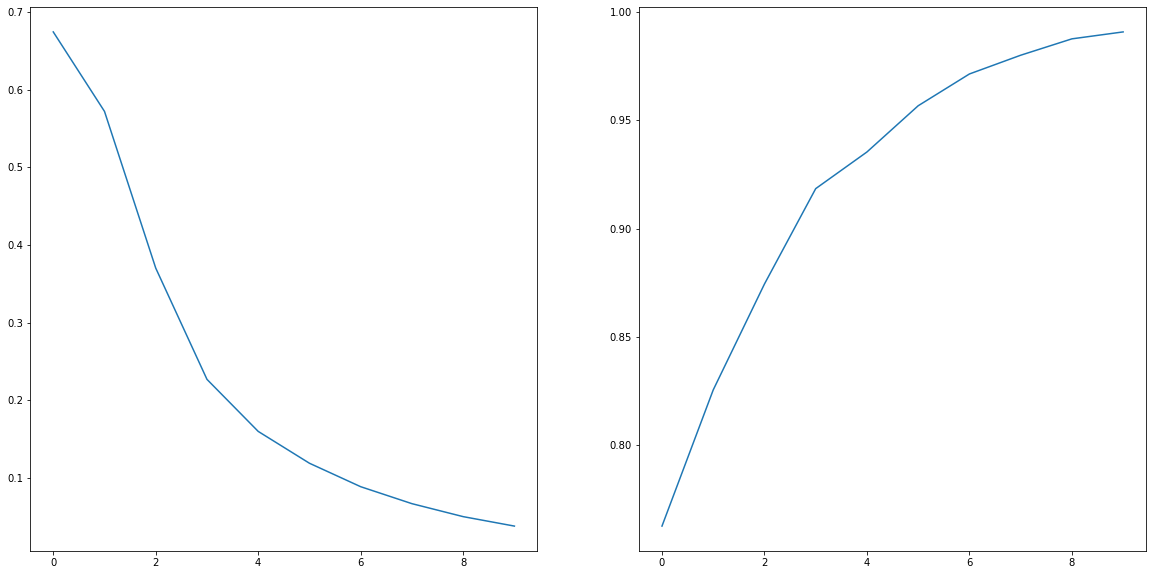

In [20]:
figure, ax = plt.subplots(1, 2)
figure.set_size_inches(20,10)

ax[0].plot(progress.history["loss"])

ax[1].plot(progress.history["accuracy"])

plt.show()

In [21]:
to_predict = data

In [22]:
X_test = to_predict["title"]
X_test

0        House Dem Aide We Didnt Even See Comeys Letter...
1         FLYNN Hillary Clinton Big Woman Campus Breitbart
2                            Why Truth Might Get You Fired
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed fictional unpublished sto...
                               ...                        
20795     Rapper TI Trump Poster Child For White Supremacy
20796    NFL Playoffs Schedule Matchups Odds The New Yo...
20797    Macys Is Said Receive Takeover Approach Hudson...
20798    NATO Russia To Hold Parallel Exercises In Balkans
20799                                 What Keeps F35 Alive
Name: title, Length: 20800, dtype: object

In [23]:
Y_test = to_predict["label"]
Y_test

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64

In [24]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   61,  748, 1210,   65,  653,
        313,  335, 1337,  652, 1532, 1702, 4093,   29])

In [25]:
predictions = model.predict(X_test)

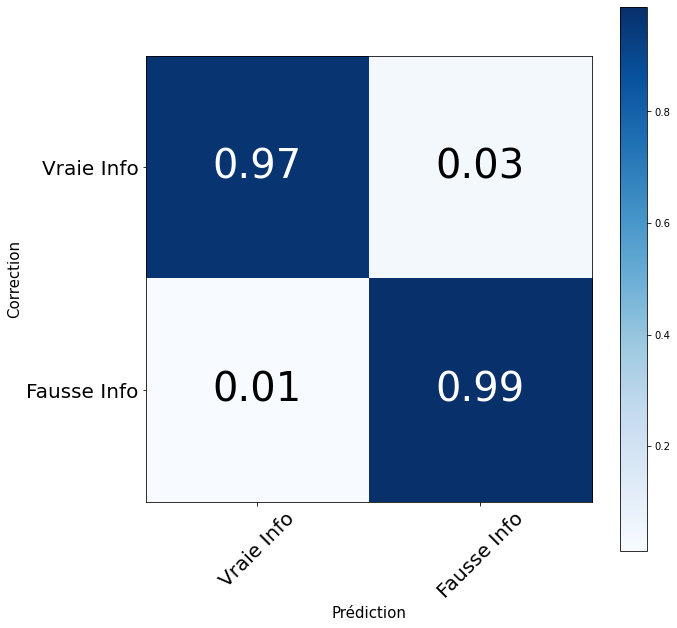

In [26]:
cm_plot_labels = ["Vraie Info","Fausse Info"]
cm = confusion_matrix(Y_test, np.round(predictions))
plot_confusion_matrix(cm, cm_plot_labels)

In [27]:
X_test

array([[   0,    0,    0, ..., 1702, 4093,   29],
       [   0,    0,    0, ...,  160, 1119,    6],
       [   0,    0,    0, ...,  100,   32,  973],
       ...,
       [   0,    0,    0, ...,    2,    3,    4],
       [   0,    0,    0, ...,  872,   13, 9771],
       [   0,    0,    0, ..., 1530, 7100, 1234]])

In [28]:
test_data = pd.read_csv("./dataset2/test.csv")
test_data.sample(10)

,id,title,author,text
1028,21828,Warning: They’re All Out Today,Gerry McBride,We Use Cookies: Our policy [X] Warning: They’r...
1856,22656,Only in Palm Beach: The $95 Million Tear-Down ...,Robert Frank,"In 2008, Donald Trump sold a Palm Beach, Fla. ..."
1155,21955,DEA Official Spills The Beans on The Clinton F...,Eddy Lavine,posted by Eddie Without much comment or fanfar...
3817,24617,"William Bratton, New York’s Influential Police...",J. David Goodman and Al Baker,"William J. Bratton, the commissioner of the Ne..."
2608,23408,How Western Media Teleported a Child 'Victim' ...,NaN,How Western Media Teleported a Child 'Victim' ...
925,21725,The Hostility and Hypocrisy of Left-Wing Israe...,Noah Beck,The Hostility and Hypocrisy of Left-Wing Israe...
1475,22275,"How Population Growth, Industrial Agriculture ...",Kshatriya Indransha,"How Population Growth, Industrial Agricultur..."
910,21710,Serena Williams Beats Venus Williams to Win He...,Christopher Clarey,"MELBOURNE, Australia — Serena Williams was ..."
1446,22246,VIRGIL: The Environmental Protection Agency --...,Virgil,Everyone’s talking about the Deep State now. ...
1071,21871,Fox Losing More Advertisers After Sexual Haras...,Emily Steel and Michael S. Schmidt,Pressure mounted on Tuesday for Fox News to ta...


In [29]:
del test_data["author"]
del test_data["text"]
test_data.sample(10)

,id,title
855,21655,WATCH - NY Assemblyman to Linda Sarsour: Expla...
3325,24125,Senior Lawyers Demand Action to Replace White ...
65,20865,Hillary Clinton’s Gun Control Agenda Exposed i...
4343,25143,Smart Meter Case Testimony Before the Pennsylv...
4276,25076,"For Leaders of U.S. Allies, Getting Close to T..."
486,21286,In Just 11 Days Scientists Destroyed Breast Ca...
2438,23238,Worn Hillary Resurfaces: “Deeply Disappointed ...
2988,23788,Can We Ignore the Alarm Bells the Bond Market ...
5074,25874,MUFON International tracking multiple triangle...
2578,23378,Women Petition U.N. Leader to Seek Korean Peac...


In [30]:
test_data["title"] = test_data["title"].apply(cleanText)
test_data.sample(10)

,id,title
1462,22262,Trump Hotels See YUGE SURGE Bookings After HIS...
92,20892,A Sour Surprise Public Pensions Two Sets Books...
255,21055,Orlando Medical Examiner Take Typical Homicide...
2006,22806,WikiLeaks Obama Is A Saudi Agent
3589,24389,Democrats KickOff Resistance Summer Trump Hous...
3825,24625,EXCLUSIVE ExGitmo Warden Disgusted Obama Relea...
4218,25018,Pactes clairs sujétion longue par Manlio Dinucci
3508,24308,Cinecôa e imaginário rupestre
118,20918,Charles Koch Makes Massive Donation Historical...
2823,23623,Georgia Lawmakers Pass Campus Carry Sending It...


In [31]:
import numpy as np

x_confirm = tokenizer.texts_to_sequences(test_data["title"])
x_confirm = pad_sequences(x_confirm, maxlen=maxlen)
labels = np.round(model.predict(x_confirm)).astype("int")

In [32]:
del test_data["title"]

In [33]:
test_data["label"] = labels
test_data.sample(10)

,id,label
1136,21936,1
4556,25356,0
4419,25219,0
2180,22980,1
4051,24851,0
2973,23773,0
4708,25508,1
1480,22280,0
3910,24710,1
2633,23433,1


In [34]:
test_data.to_csv("submission.csv", index=False)